In [4]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [15]:
from utils.common import sigmoid, reverse_sigmoid
from utils.constants import *
from utils.extraction_helpers import read_file

In [16]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Data

In [19]:
chris  = read_file(f"{SUBMISSION_DATA_PATH}/sorted_chris.csv")
waikey = read_file(f"{SUBMISSION_DATA_PATH}/wk_seed_6666.csv")
ensemble = read_file(f"{SUBMISSION_DATA_PATH}/others_ensemble.csv")
exp_ensemble = read_file(f"{SUBMISSION_DATA_PATH}/others_exponential_ensemble.csv")
blend_trees = read_file(f"{SUBMISSION_DATA_PATH}/others_blend_boosted_tree.csv")

Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)


In [39]:
waikey["sigmoid_prediction"] = waikey["prediction"].apply(sigmoid)

In [36]:
chris["reverse_sigmoid_prediction"] = chris["prediction"].apply(reverse_sigmoid)
ensemble["reverse_sigmoid_prediction"] = ensemble["prediction"].apply(reverse_sigmoid)
exp_ensemble["reverse_sigmoid_prediction"] = exp_ensemble["prediction"].apply(reverse_sigmoid)
blend_trees["reverse_sigmoid_prediction"] = blend_trees["prediction"].apply(reverse_sigmoid)

In [44]:
pre_blend_df = pd.DataFrame(
    dict(
        wk=waikey["sigmoid_prediction"],
        chris=chris["prediction"],
        ensemble=ensemble["prediction"],
        exp_ensemble=exp_ensemble["prediction"],
        blend_trees=blend_trees["prediction"]
    )
)

In [55]:
mscaler = MinMaxScaler()
s1 = mscaler.fit_transform(pre_blend_df[["ensemble"]])[:, 0]
s2 = mscaler.fit_transform(pre_blend_df[["blend_trees"]])[:, 0]

In [57]:
pre_blend_df["tree_ensemble"] = 0.5 * (s1 + s2)

In [59]:
pre_blend_df = pre_blend_df.drop(columns=["blend_trees", "ensemble"], errors="ignore")

In [66]:
mscaler = MinMaxScaler()
pre_blend_df["exp_ensemble"] = mscaler.fit_transform(pre_blend_df[["exp_ensemble"]])[:, 0]

In [67]:
pre_blend_df.corr()

,wk,chris,exp_ensemble,tree_ensemble
wk,1.000000,0.975540,0.984327,0.996770
chris,0.975540,1.000000,0.979640,0.975682
exp_ensemble,0.984327,0.979640,1.000000,0.990506
tree_ensemble,0.996770,0.975682,0.990506,1.000000


In [73]:
ori_columns = pre_blend_df.columns.tolist()

In [76]:
pre_blend_df["simple_average"] = pre_blend_df[ori_columns].mean(axis=1)

In [77]:
pre_blend_df

,wk,chris,exp_ensemble,tree_ensemble,simple_average
0,0.017929,0.050863,0.203048,0.069515,0.085339
1,0.000551,0.001664,0.019959,0.005645,0.006955
2,0.031305,0.027053,0.208046,0.071866,0.084568
3,0.206866,0.688397,0.366104,0.235737,0.374276
4,0.883933,0.949558,0.872776,0.861400,0.891917
...,...,...,...,...,...
924616,0.014923,0.045180,0.121147,0.042261,0.055878
924617,0.893580,0.931766,0.842889,0.820062,0.872074
924618,0.449637,0.717965,0.570566,0.486275,0.556110
924619,0.285664,0.552849,0.415526,0.289983,0.386005


In [ ]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = 0.55 * pre_blend_df["wk"] + 0.15 * (pre_blend_df["chris"] + pre_blend_df["tree_ensemble"] + pre_blend_df["exp_ensemble"])
sub.to_csv(f"{SUBMISSION_DATA_PATH}/gambling1.csv", index=False)

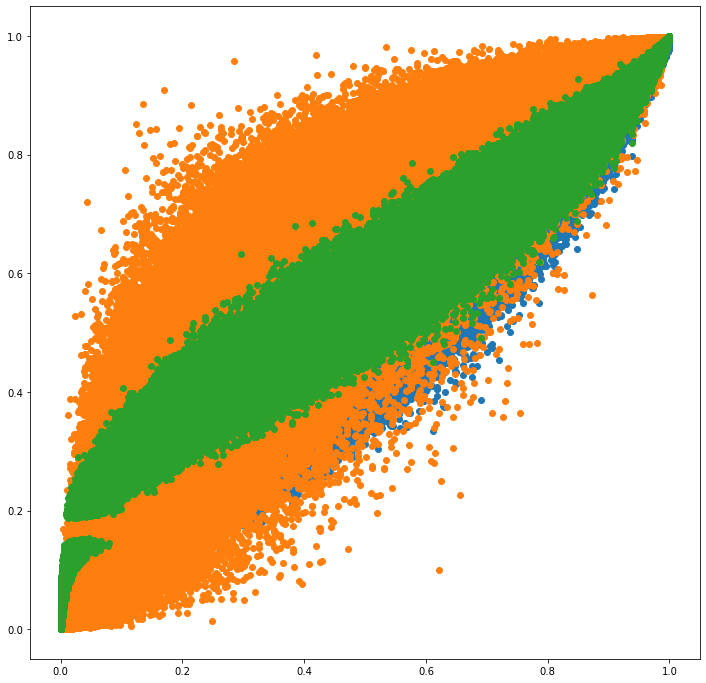

In [69]:
fig, ax = plt.subplots(figsize=(12, 12))
# plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="orange", linestyle="-")
# plt.xlabel("WK Blend")
# plt.ylabel("Chris best NN")
plt.scatter(pre_blend_df["wk"], pre_blend_df["tree_ensemble"])
plt.scatter(pre_blend_df["wk"], pre_blend_df["chris"])
plt.scatter(pre_blend_df["wk"], pre_blend_df["exp_ensemble"])
# plt.scatter(ensemble["prediction"], blend_trees["prediction"])
# plt.scatter(s1, s3)
plt.show()

In [47]:
# result_sub1 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission105_blend_with_4seeds_hope_for_0.801_again.csv")
# result_sub1["prediction"] = result_sub1["prediction"].apply(reverse_sigmoid)

In [48]:
# result_sub2 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/chris_nn_0.7933788_custom_embed.csv")
# result_sub2 = result_sub2.sort_values(by="customer_ID").reset_index(drop=True)
result_sub2["prediction"] = result_sub2["prediction"].apply(reverse_sigmoid)

In [54]:
# result_sub2["prediction"] = pd.Series(s2).apply(sigmoid)

In [55]:
# result_sub1["prediction"] = np.where(result_sub1["prediction"] > 15, 10, result_sub1["prediction"])
# result_sub1["prediction"] = np.where(result_sub1["prediction"] < -15, -10, result_sub1["prediction"])

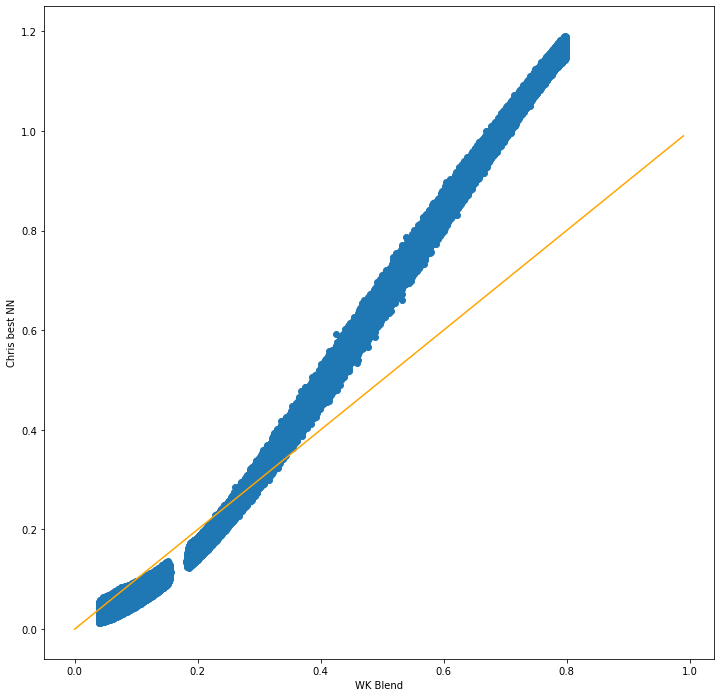

In [68]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")

In [69]:
sub["prediction"] = (
    0.53 * result_sub1["prediction"] + 0.13 * result_sub2["prediction"] 
    + 0.13 * result_sub3["prediction"] + 0.21 * result_sub4["prediction"]
)

In [70]:
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_blend_my_team_best_with_exponential_ensemble_5th.csv", index=False)

In [67]:
# np.corrcoef(sub["me"], sub["other"])

In [60]:
sub.describe()

,me,other
count,924621.000000,924621.000000
mean,-2.940645,-1.208755
std,3.575642,1.337941
min,-10.053445,-3.184661
25%,-5.984249,-2.302388
50%,-3.704030,-1.459412
75%,-0.120470,-0.086237
max,8.281089,1.382695


In [61]:
np.corrcoef(result_sub2["prediction"], result_sub1["prediction"])

array([[1.       , 0.9895066],
       [0.9895066, 1.       ]])

In [78]:
sub["pred1"] = result_sub1["prediction"]
sub["pred2"] = result_sub2["prediction"]

In [79]:
sub

,customer_ID,prediction,pred1,pred2
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025609,0.021981,0.046170
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001721,0.001598,0.002418
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.025882,0.026609,0.021763
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.219855,0.133614,0.708557
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.938350,0.935005,0.957303
...,...,...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.020279,0.014413,0.053520
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.932468,0.931950,0.935400
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.500896,0.458484,0.741229
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.278340,0.224287,0.584639


In [11]:
result_sub1.loc[result_sub1["prediction"].between(-13, 13), "prediction"].describe()

count    924621.000000
mean         -2.422726
std           3.408775
min         -10.401408
25%          -5.098521
50%          -3.736096
75%           0.159021
max          10.000000
Name: prediction, dtype: float64

In [12]:
result_sub2["prediction"].describe()

count    924621.000000
mean         -2.072434
std           3.676355
min          -7.518958
25%          -5.332178
50%          -2.822755
75%           0.926208
max           7.470797
Name: prediction, dtype: float64

In [17]:
mscaler = MinMaxScaler()
s1 = mscaler.fit_transform(result_sub1[["prediction"]])[:, 0]
s2 = mscaler.fit_transform(result_sub2[["prediction"]])[:, 0]

In [18]:
s2

array([0.06325669, 0.00152818, 0.03142791, ..., 0.7203658 , 0.574496  ,
       0.14806519])

In [19]:
s1

array([0.02198081, 0.00159815, 0.02660928, ..., 0.45848391, 0.22428659,
       0.03456198])

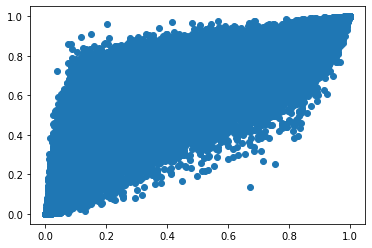

In [20]:
plt.scatter(s1, s2)
plt.show()

In [51]:
result_sub1["prediction"] += result_sub2["prediction"]
result_sub1["prediction"] /= 2

In [55]:
sub = sub.merge(result_sub1, on="customer_ID", how="left")

In [56]:
sub.to_csv(f"{SUBMISSION_DATA_PATH}/revised_submission_106th_try_blend_chris.csv", index=False)

In [105]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = 0.8 * s1 + 0.2 * s2
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_109th_blend_best_with_chris_min_max_scaler.csv", index=False)

In [ ]:
merged_result["prediction"] = 0.55 * mega_df["prediction_x"] + 0.45 * mega_df["prediction_y"]
mega_df = mega_df.drop(columns=["prediction_x", "prediction_y"])

In [ ]:
mega_df.to_csv(f"{SUBMISSION_DATA_PATH}/submission18.csv", index=False)

#### Take weighted average of 2 prediction scores

In [52]:
merged_result["prediction"] = merged_result["prediction_x"].rank() * 0.7 + merged_result["prediction_y"].rank() * 0.3
# merged_result["prediction"] = 0.6 * merged_result["prediction_x"] + 0.4 * merged_result["prediction_y"]

In [53]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"], errors="ignore")

In [54]:
if merged_result.shape == (924621, 2) and merged_result.columns.tolist() == ['customer_ID', 'prediction']:
    merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission31.csv", index=False)

In [48]:
merged_result["x_positive"] = (merged_result["prediction_x"] >= 0)

In [49]:
merged_result["y_positive"] = (merged_result["prediction_y"] >= 0)

In [50]:
neg_neg_indices = merged_result.loc[(~merged_result["x_positive"]) & (~merged_result["y_positive"])].index

In [51]:
merged_result.loc[neg_neg_indices, "prediction"] = merged_result.loc[neg_neg_indices, :].min(axis=1)

In [52]:
pos_pos_indices = merged_result.loc[(merged_result["x_positive"]) & (merged_result["y_positive"])].index

In [53]:
merged_result.loc[pos_pos_indices, "prediction"] = merged_result.loc[pos_pos_indices, :].max(axis=1)

In [54]:
merged_result["prediction"].isnull().sum()

25395

In [55]:
merged_result.loc[merged_result["prediction"].isnull(), "prediction"] = \
(merged_result.loc[merged_result["prediction"].isnull(), "prediction_x"] + \
merged_result.loc[merged_result["prediction"].isnull(), "prediction_y"]) / 2

In [56]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"])

In [58]:
merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission24.csv", index=False)

In [20]:
new_result_sub["prediction"] = np.max([new_result_sub["prediction"].values, old_result_sub["prediction"].values], axis=0)

In [27]:
new_result_sub["prediction"] += old_result_sub["prediction"]

In [28]:
new_result_sub["prediction"] /= 2

In [30]:
new_result_sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission22.csv", index=False)

In [ ]:
result_sub = test_agg.loc[:, [c for c in test_agg.columns if c.startswith("score")]].mean(axis=1).reset_index()

In [ ]:
result_sub.columns = ["customer_ID", "prediction"]

In [ ]:
result_sub.to_csv("submission20.csv", index=False)

In [ ]:
single_record_index = test_agg.loc[test_agg["num_records"] == 1].index.tolist()

In [ ]:
final_df13 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission13_0.796.csv")
final_df13["prediction_13"] = sigmoid(final_df13["prediction"])
final_df13 = final_df13.drop(columns="prediction")

In [ ]:
final_df16 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission16_0.782.csv")
final_df16["prediction_16"] = sigmoid(final_df16["prediction"])
final_df16 = final_df16.drop(columns="prediction")

In [ ]:
mega_df = final_df13.merge(final_df16, on="customer_ID", how="left")

In [ ]:
mega_df.loc[:, "prediction"] = (
    mega_df.loc[:, "prediction_16"] * 0.1 \
    + mega_df.loc[:, "prediction_13"] * 0.9
)

In [ ]:
mega_df.loc[single_record_index, "prediction"] = (
    mega_df.loc[single_record_index, "prediction_16"] * 0.8 \
    + mega_df.loc[single_record_index, "prediction_13"] * 0.2
)

In [ ]:
mega_df = mega_df.drop(columns=["prediction_13", "prediction_16"])